In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm 
import random
# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

## Inspect and clean

In [ ]:
## Import dataset from Github, exclude unessaracy columns
df = pd.read_csv('https://raw.githubusercontent.com/tuananhnguyen527/strokeanalysis/main/healthcare-dataset-stroke-data.csv', usecols= lambda x: x != 'id')

In [ ]:
df.head(5)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


This data include health indicators of an individuals like their age, average glucose level, bmi, smoking status; whether they have hypertension, heart disease or stroke. ALong with that are some characteristics like Gender, Work Type, Residence Type, Marriage status.

We want to predict the probability of people who get stroke from this dataset, which make 'stroke' our dependent variables with other 10 independeneces.

Data types:

_ continuous: avg_glucose_level, bmi, age

_ Categoral: gender, work_type, residence_type, smoking_status.

_ Binary: hypertension, heart_disease, ever_married, stroke

In [ ]:
## Standardize all column names
df.columns = df.columns.str.lower()

In [ ]:
# Missing data summary
df.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

### Standardize Categorical values

In [ ]:
# All lower case to values, replace '-' by '_'
df[['gender', 'work_type', 'residence_type', 'smoking_status']] = df[['gender', 'work_type', 'residence_type', 'smoking_status']].applymap(lambda x: x.lower().replace('-', '_'))

In [ ]:
# Unique values of categories. Inspect any null.
for i in ['gender', 'work_type', 'residence_type', 'smoking_status']:
  print(i)
  print( df[i].unique())

gender
['male' 'female' 'other']
work_type
['private' 'self_employed' 'govt_job' 'children' 'never_worked']
residence_type
['urban' 'rural']
smoking_status
['formerly smoked' 'never smoked' 'smokes' 'unknown']


No null detected from categorical values. All values are consistent and need no further cleanup

In [ ]:
# Standardize binomial from yes/no to 0/1.
df['ever_married'] = df['ever_married'].map({'Yes': 1, 'No': 0})

The data only missing 201 values in BMI, showing no significant patterns of missing values.

### Continuous variables data validation



In [ ]:
# Check for negative values
df[(df['age'] < 0) | (df['avg_glucose_level'] < 0) | (df['bmi'] <0)]

,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke


Will inspect more on continuous variables in EDA

## EDA

## Summary

People who have stroke are in significant high ages, with median age of 71. Also, people with hypertension are more likely to also have stroke, with 26.5% compared to only 8% of people without hypertension. The same trend is recognised for people with heart desease, 18% of them also have stroke while only 4% have stroke without a heart desease.

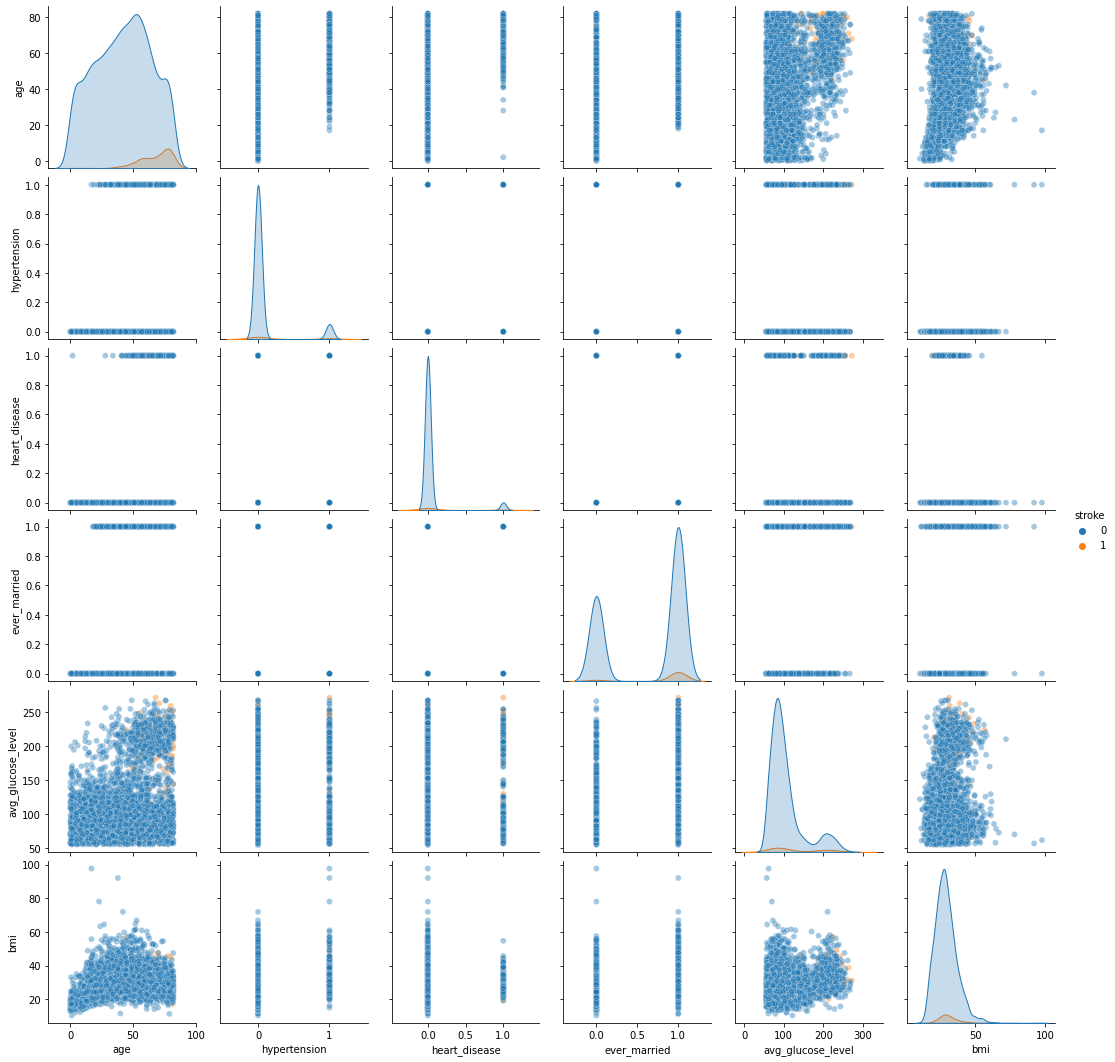

In [ ]:
sns.pairplot(data = df, hue = 'stroke', kind = 'scatter', plot_kws={'alpha':0.4})

First look into the pairplot: 

_ It does not look like we have a clear relationship between any continous variables.

_ Stroke group is under-represented while non-stroke class is dominant in population.


### Continuous variables

#### Age

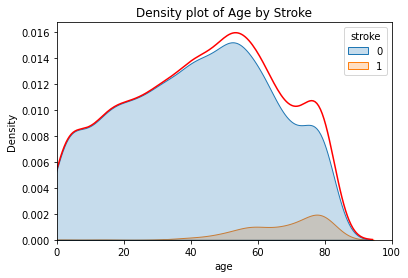

In [ ]:
## Density plot for age distribution
sns.kdeplot(data = df, x = 'age', hue = 'stroke', shade = True)
plt.xlim(0,100)
plt.title('Density plot of Age by Stroke')

sns.kdeplot(data = df, x = 'age',color = 'red')

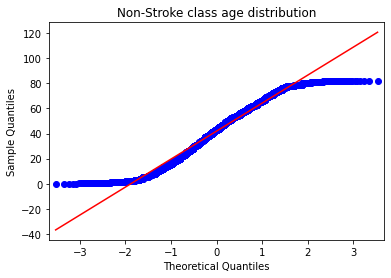

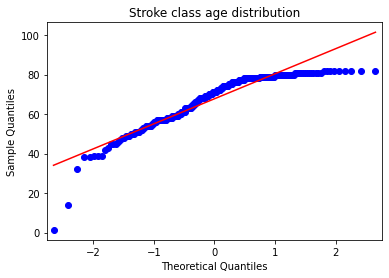

In [ ]:
sm.qqplot(df.loc[df['stroke'] == 0,'age'], line = 's')
plt.title('Non-Stroke class age distribution')

sm.qqplot(df.loc[df['stroke'] == 1,'age'], line = 's')
plt.title('Stroke class age distribution')
plt.show()

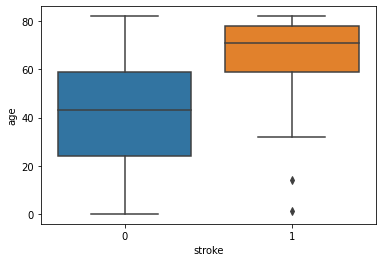

In [ ]:
sns.boxplot(data = df, y = 'age', x = 'stroke')

In [ ]:
## Numerical summary of age based on dependent classes
df[['age', 'stroke']].groupby('stroke').describe()

age                                                    
         count       mean        std   min   25%   50%   75%   max
stroke                                                            
0       4861.0  41.971545  22.291940  0.08  24.0  43.0  59.0  82.0
1        249.0  67.728193  12.727419  1.32  59.0  71.0  78.0  82.0

The quantile plots indicates age of non-stroke class is normally distributed while age of stroke class is negatively skewed. The boxpllot indicates the mean of stroke class is higher than mean age of non-stroke class, the interquantile (middle half of data) of stroke class is higher than non-stroke class.

Since stroke class have skewd distribution, we use median age to compared the center of the distribution.

##### Hypothesis Test

The median age of non-stroke group is 43 while median age of stroke- group is 71. We want to test if the median difference is statistically significant.

_H0: Median age difference of stroke and non-stroke classes is 0.

_H1: Median age of people who have stroke is higher than median age of people who do not have stroke.

In [ ]:
n = len(df['age'])
stroke_n = len(df.loc[df['stroke']== 1, 'age'])
observed = df.loc[df['stroke'] == 1, 'age'].median() - df.loc[df['stroke'] == 0, 'age'].median()
median_diff = []
N = 10 ** 4 -1
# Permutation test
for i in range(N):
  index = random.sample(list(df.index), stroke_n)
  median_diff.append(df.loc[df.index.isin(index),'age'].median() - df.loc[~df.index.isin(index),'age'].median())

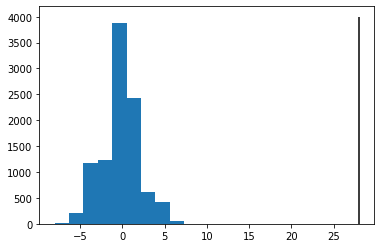

In [ ]:
plt.hist(median_diff)
plt.vlines(x = observed, ymin = 0, ymax = 4000)

In [ ]:
# p-value
(sum(median_diff >= observed) + 1) / (N + 1)

0.0001

p-value = 0.0001, indicating that the observed median difference only happen 0.01% by chance. With 99% confidence, we could conclude that median age of stroke class is higher than median age of non-stroke class.

#### Average Glucose Level

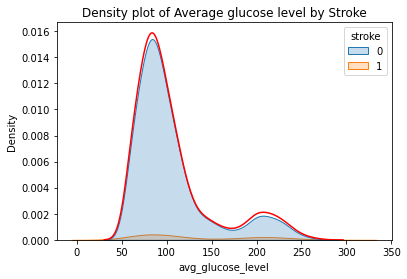

In [ ]:
## Density plot for age distribution
sns.kdeplot(data = df, x = 'avg_glucose_level', hue = 'stroke', shade = True)
plt.title('Density plot of Average glucose level by Stroke')

sns.kdeplot(data = df, x = 'avg_glucose_level',color = 'red')

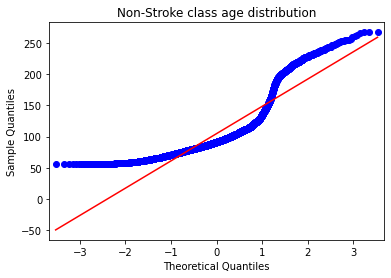

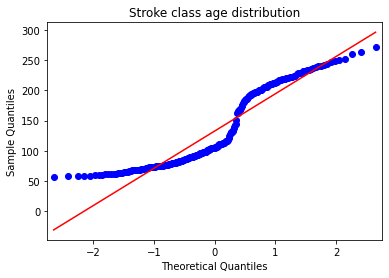

In [ ]:
sm.qqplot(df.loc[df['stroke'] == 0,'avg_glucose_level'], line = 's')
plt.title('Non-Stroke class age distribution')

sm.qqplot(df.loc[df['stroke'] == 1,'avg_glucose_level'], line = 's')
plt.title('Stroke class age distribution')
plt.show()

The distribution of all Average glucose level is bimodal, consistent in both classes

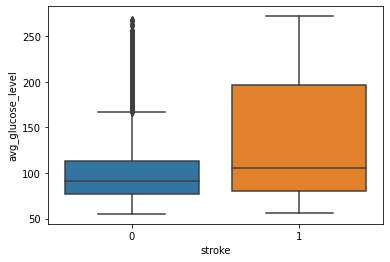

In [ ]:
sns.boxplot(data = df, y = 'avg_glucose_level', x = 'stroke')

In [ ]:
## Numerical summary of average glucose level based on dependent classes
df[['avg_glucose_level', 'stroke']].groupby('stroke').describe()

avg_glucose_level                                                       \
                   count        mean        std    min    25%     50%     75%   
stroke                                                                          
0                 4861.0  104.795513  43.846069  55.12  77.12   91.47  112.83   
1                  249.0  132.544739  61.921056  56.11  79.79  105.22  196.71   

                
           max  
stroke          
0       267.76  
1       271.74

Average Glucose level from both group have pretty similar minimum and maximum, but the interquartile range of stroke class spread from 79 to 196 while interquartile of non-stroke class is much denser from 77 to 112. 

However, from the boxplot, we can see non-stroke group have outlier starting somewhere near 160. Combined with bimodel distribution, this need further investigation.

#### BMI

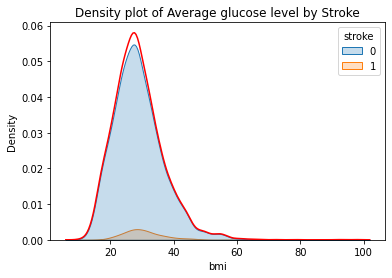

In [ ]:
## Density plot for age distribution
sns.kdeplot(data = df, x = 'bmi', hue = 'stroke', shade = True)
plt.title('Density plot of Average glucose level by Stroke')

sns.kdeplot(data = df, x = 'bmi',color = 'red')

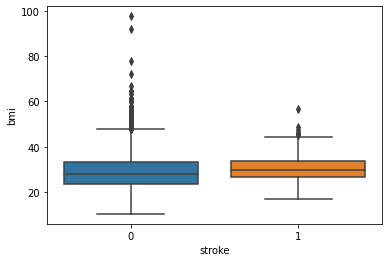

In [ ]:
sns.boxplot(data = df, y = 'bmi', x = 'stroke')

In [ ]:
## Numerical summary of average glucose level based on dependent classes
df[['bmi', 'stroke']].groupby('stroke').describe()

bmi                                                   
         count       mean       std   min   25%   50%   75%   max
stroke                                                           
0       4700.0  28.823064  7.908287  10.3  23.4  28.0  33.1  97.6
1        209.0  30.471292  6.329452  16.9  26.4  29.7  33.7  56.6

BMI distributions from both classes are normal, with average bmi of non-stroke class is 28 compared to 30.4 of stroke class.

However, we see the interquartile of stroke class is more dense and 

##### Hypothesis Test

Test if average difference of stroke class and non-stroke class is statistically significant.

H0: Average BMI between non-stroke and stroke classes are similar.

H1: Average BMI of stroke class is higher than aerage BMI of non-stroke class.

In [ ]:
n = len(df['avg_glucose_level'])
stroke_n = len(df.loc[df['stroke']== 1, 'avg_glucose_level'])
observed = df.loc[df['stroke'] == 1, 'avg_glucose_level'].mean() - df.loc[df['stroke'] == 0, 'avg_glucose_level'].mean()
mean_diff = []
N = 10 ** 4 -1
# Permutation test
for i in range(N):
  index = random.sample(list(df.index), stroke_n)
  median_diff.append(df.loc[df.index.isin(index),'avg_glucose_level'].mean() - df.loc[~df.index.isin(index),'avg_glucose_level'].mean())

In [ ]:
# p-value
(sum(mean_diff >= observed) + 1) / (N + 1)

0.0001

p-value is 0.0001, indicating the chance of our observed average difference between 2 classes is 0.01%. The evidence support that average BMI of stroke class is higher than averiage BMI of non-stroke class.

### Binomial variables

#### Ever Mariaged

In [ ]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,male,67.0,0,1,1,private,urban,228.69,36.6,formerly smoked,1
1,female,61.0,0,0,1,self_employed,rural,202.21,NaN,never smoked,1
2,male,80.0,0,1,1,private,rural,105.92,32.5,never smoked,1
3,female,49.0,0,0,1,private,urban,171.23,34.4,smokes,1
4,female,79.0,1,0,1,self_employed,rural,174.12,24.0,never smoked,1


In [ ]:
# Coutn by Stroke and Marriage groupby, make stroke column index
marriage_stroke = df.groupby(['stroke', 'ever_married']).count()['gender'].reset_index(level = 1)

#Merge with stroke count
marriage_stroke = pd.merge(marriage_stroke, df['stroke'].value_counts(), left_index = True, right_index = True) 

marriage_stroke.columns = ['ever_married', 'ever_married_count','stroke_count']
marriage_stroke['strokeper'] = marriage_stroke['ever_married_count'] / marriage_stroke['stroke_count']

In [ ]:
marriage_stroke

,ever_married,ever_married_count,stroke_count,strokeper
0,0,1728,4861,0.355482
0,1,3133,4861,0.644518
1,0,29,249,0.116466
1,1,220,249,0.883534


#### Hypertension

In [ ]:
# Coutn by Stroke and Hypertension
hyper_stroke = df.groupby(['stroke', 'hypertension']).count()['gender'].reset_index(level = 1)

#Merge with stroke count
hyper_stroke = pd.merge(hyper_stroke, df['stroke'].value_counts(), left_index = True, right_index = True) 

# Hypertension percentage against stroke
hyper_stroke.columns = ['hypertension', 'hypertension_count','stroke_count']
hyper_stroke['strokeper'] = hyper_stroke['hypertension_count'] / hyper_stroke['stroke_count']

In [ ]:
hyper_stroke

,hypertension,hypertension_count,stroke_count,strokeper
0,0,4429,4861,0.911129
0,1,432,4861,0.088871
1,0,183,249,0.734940
1,1,66,249,0.265060


#### Heart Desease

In [ ]:
# Coutn by Stroke and Heart Disease
heart_stroke = df.groupby(['stroke', 'heart_disease']).count()['gender'].reset_index(level = 1)

#Merge with stroke count
heart_stroke = pd.merge(heart_stroke, df['stroke'].value_counts(), left_index = True, right_index = True) 

# Hypertension percentage against stroke
heart_stroke.columns = ['hypertension', 'heartdisease_count','stroke_count']
heart_stroke['strokeper'] = heart_stroke['heartdisease_count'] / marriage_stroke['stroke_count']

In [ ]:
heart_stroke.reset_index()

,index,hypertension,heartdisease_count,stroke_count,strokeper
0,0,0,4632,4861,0.952890
1,0,1,229,4861,0.047110
2,1,0,202,249,0.811245
3,1,1,47,249,0.188755


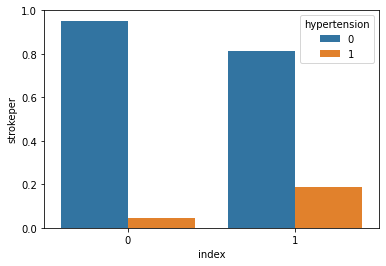

In [ ]:
sns.barplot(data = heart_stroke.reset_index(), y = 'strokeper', x = 'index', hue = 'hypertension')

In [ ]:
# Coutn by Stroke and Heart Disease
hyper_heart_stroke = df.groupby(['stroke', 'heart_disease', 'hypertension']).count()['gender'].reset_index()

#Merge with stroke count
hyper_heart_stroke = pd.merge(hyper_heart_stroke, df['stroke'].value_counts(), left_on = 'stroke', right_index = True) 
hyper_heart_stroke = 

# Hypertension percentage against stroke

hyper_heart_stroke['strokeper'] = heart_stroke['heartdisease_count'] / marriage_stroke['stroke_count']

,stroke,stroke_x,heart_disease,hypertension,gender,stroke_y
0,0,0,0,0,4251,4861
1,0,0,0,1,381,4861
2,0,0,1,0,178,4861
3,0,0,1,1,51,4861
4,1,1,0,0,149,249
5,1,1,0,1,53,249
6,1,1,1,0,34,249
7,1,1,1,1,13,249


### Categorical variables

#### Smoking Status

In [ ]:
# Coutn by Stroke and Heart Disease
smoke_stroke = df.groupby(['stroke', 'smoking_status']).count()['gender'].reset_index()

#Merge with stroke count
smoke_stroke = pd.merge(smoke_stroke, df['smoking_status'].value_counts(), left_on = 'smoking_status', right_index = True) 
smoke_stroke = smoke_stroke.drop('smoking_status_x', axis = 1)
# Hypertension percentage against stroke
smoke_stroke.columns = ['smoking_status','stroke', 'smokingstatus_count','stroke_count']
smoke_stroke['strokeper'] = smoke_stroke['smokingstatus_count'] / smoke_stroke['stroke_count']

In [ ]:
smoke_stroke

,smoking_status,stroke,smokingstatus_count,stroke_count,strokeper
0,formerly smoked,0,815,885,0.920904
4,formerly smoked,1,70,885,0.079096
1,never smoked,0,1802,1892,0.952431
5,never smoked,1,90,1892,0.047569
2,smokes,0,747,789,0.946768
6,smokes,1,42,789,0.053232
3,unknown,0,1497,1544,0.969560
7,unknown,1,47,1544,0.030440


Formerly Smoked group have the highest of stroke percentage, 7.9%, compared to active smoking group of 5.3% and never smoked of 4.8%. 

#### Residence Type

In [ ]:
# Coutn by Stroke and Resident Type
res_stroke = df.groupby(['stroke', 'residence_type']).count()['gender'].reset_index()

#Merge with stroke count
res_stroke = pd.merge(res_stroke, df['residence_type'].value_counts(), left_on = 'residence_type', right_index = True) 
res_stroke = res_stroke.drop('residence_type_x', axis = 1)
# Hypertension percentage against stroke
res_stroke.columns = ['residence_type','stroke', 'residence_count','stroke_count']
res_stroke['strokeper'] = res_stroke['residence_count'] / res_stroke['stroke_count']

In [ ]:
res_stroke

,residence_type,stroke,residence_count,stroke_count,strokeper
0,rural,0,2400,2514,0.954654
2,rural,1,114,2514,0.045346
1,urban,0,2461,2596,0.947997
3,urban,1,135,2596,0.052003


Rural residents are 4.5% likely to get stroke while Urban residents are 5.2% likely to get stroke.

#### Work Type

In [ ]:
# Coutn by Stroke and Resident Type
work_stroke = df.groupby(['stroke', 'work_type']).count()['gender'].reset_index()

#Merge with stroke count
work_stroke = pd.merge(work_stroke, df['work_type'].value_counts(), left_on = 'work_type', right_index = True) 
work_stroke = work_stroke.drop('work_type_x', axis = 1)
# Hypertension percentage against stroke
work_stroke.columns = ['work_type','stroke', 'worktype_count','stroke_count']
work_stroke['strokeper'] = work_stroke['worktype_count'] / work_stroke['stroke_count']

In [ ]:
work_stroke

,work_type,stroke,worktype_count,stroke_count,strokeper
0,children,0,685,687,0.997089
5,children,1,2,687,0.002911
1,govt_job,0,624,657,0.949772
6,govt_job,1,33,657,0.050228
2,never_worked,0,22,22,1.000000
3,private,0,2776,2925,0.949060
7,private,1,149,2925,0.050940
4,self_employed,0,754,819,0.920635
8,self_employed,1,65,819,0.079365


Self Employed group have a 7.9% to get stroke while Government and Private sector have aroudn 5%. Children is low with 0.02% chances.